In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import astropy.io.fits as fits

import pysm3
import pysm3.units as u

import healpy as hp

from fgbuster import (CMB, Dust, Synchrotron,xForecast,
                      basic_comp_sep,get_sky,
                      get_observation, get_instrument,get_noise_realization)
from fgbuster.visualization import corner_norm

from functools import partial
from scipy.interpolate import griddata
from skimage.restoration import inpaint

import sys
sys.path.append('/home/rguidetti')
from PolAngle import *
from beam import * 
from map import *
from convolution import * 
from beam_class import *
from PatchFunctions import *  # nuove funzioni in quanto quelle vecchie lavoravano con mappe NxN. Queste funzionano per mappe rettangolari Nx,Ny

Mappa originale in 1D -> Q_40

Mappa con patch originale 2D -> maps_2d['mp_hp_Q40']

Mappa (patch) con beam 2D -> Q_conv_real_40

Mappa (patch) con beam + angle 2D -> Q_polangle_40

Mappa (patch) con beam + angle + ap 2D -> Q_ap_40

Mappa (patch) con beam + angle + ap 1D -> flatten_maps['Q_flat40']

CMB (patch) con beam + angle + ap 1D -> cmb_I

CMB (patch) con beam + angle + ap 2D -> cmb_I_2d

CMB (patch) deconvoluta 2D -> I_deconv

# Inizializzazione mappa

In [2]:
nside = 64

sky = get_sky(nside, 'd1s1')
instrument = get_instrument('LiteBIRD')
freq_maps = get_observation(instrument, sky)


pix_area_deg = hp.pixelfunc.nside2pixarea(nside, degrees=True) # degrees
pix_size_deg = np.sqrt(pix_area_deg) # degrees
pix_size = pix_size_deg *60 #arcmin
pix_size

print(f"With nside = {nside}, the pixel size is {pix_size} arcmin ({pix_size_deg} degrees)")

With nside = 64, the pixel size is 54.96778258907849 arcmin (0.9161297098179748 degrees)


In [3]:
# seleziono solo alcune frequenze per comodità (8 su 15) 

mappa40  = freq_maps[0, :, :]
mappa60  = freq_maps[2, :, :]
mappa78  = freq_maps[4, :, :]
mappa100 = freq_maps[6, :, :]
mappa140 = freq_maps[8, :, :]
mappa195 = freq_maps[10, :, :]
mappa280 = freq_maps[12, :, :]
mappa402 = freq_maps[14, :, :]


##############################################################

I40 = mappa40[0,:]
Q40 = mappa40[1,:]
U40 = mappa40[2,:]

I60 = mappa60[0,:]
Q60 = mappa60[1,:]
U60 = mappa60[2,:]

I78 = mappa78[0,:]
Q78 = mappa78[1,:]
U78 = mappa78[2,:]

I100 = mappa100[0,:]
Q100 = mappa100[1,:]
U100 = mappa100[2,:]

I140 = mappa140[0,:]
Q140 = mappa140[1,:]
U140 = mappa140[2,:]

I195 = mappa195[0,:]
Q195 = mappa195[1,:]
U195 = mappa195[2,:]

I280 = mappa280[0,:]
Q280 = mappa280[1,:]
U280 = mappa280[2,:]

I402 = mappa402[0,:]
Q402 = mappa402[1,:]
U402 = mappa402[2,:]

np.shape(I40)

(49152,)

# Creazione patch

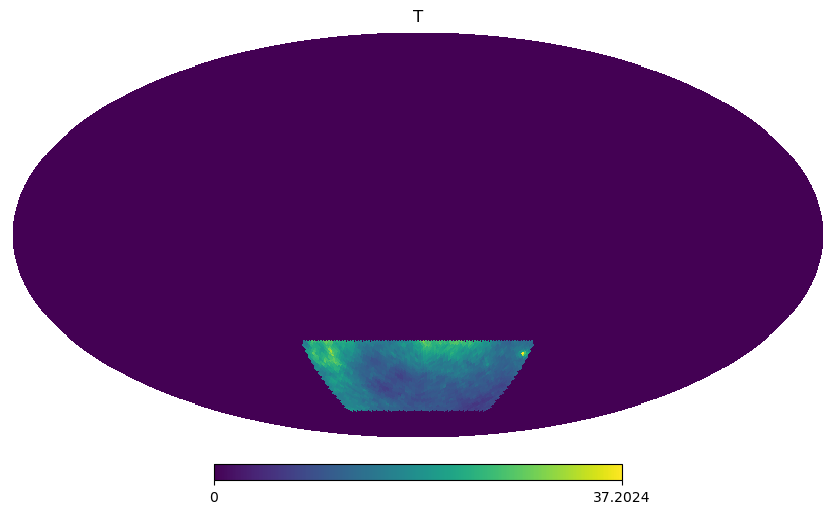

In [4]:
# patch
RA1 = -60 
RA2 = 60
dec1 = -70
dec2 = -40
idxs, resol = create_rectangular_patch([RA1, RA2], [dec1, dec2], nside)

##############################################################################


map_array= [I40, Q40, U40, 
            I60, Q60, U60, 
            I78, Q78, U78, 
            I100, Q100, U100, 
            I140, Q140, U140, 
            I195, Q195, U195, 
            I280, Q280, U280, 
            I402, Q402, U402 ]


for map in map_array:

    visualize_patch = map.copy()

    mask = np.zeros_like(visualize_patch, dtype=bool)
    mask[idxs] = True

    visualize_patch[~mask] = hp.UNSEEN

    map[~mask] = 0.0
    
    
    
hp.mollview(I40, title='T')

### Conversion 1D -> 2D

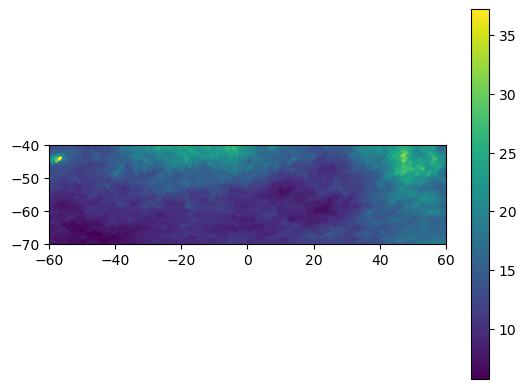

In [5]:
maps_2d = {}
extent=(RA1, RA2, dec1, dec2)

bands = ['40', '60', '78', '100', '140', '195', '280', '402']
types = ['I', 'Q', 'U']


for band in bands:
    for map_type in types:
        map_name = f"{map_type}{band}"
        map_data = globals()[map_name]
        variable_prefix = f"{map_type}{band}"
        
        mp_hp, ra_hp, dec_hp = convert2grid(map_data, nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)
        
        maps_2d[f"mp_hp_{variable_prefix}"] = mp_hp
        maps_2d[f"ra_hp_{variable_prefix}"] = ra_hp
        maps_2d[f"dec_hp_{variable_prefix}"] = dec_hp
        #print(f"Stored variables for: {variable_prefix}") 

        
plt.figure()
plt.imshow(maps_2d['mp_hp_I40'],origin='lower', extent=extent)
plt.colorbar()

# DIMENSIONI MAPPE

In [6]:
Ny, Nx = np.shape(maps_2d['mp_hp_I40']) 
print(Nx, Ny)

X_width = Nx * pix_size/60
Y_width = Ny * pix_size/60

# color map
c_min, c_max     = -10, 10  

393 99


# Beam

ellipticity =  -0.2


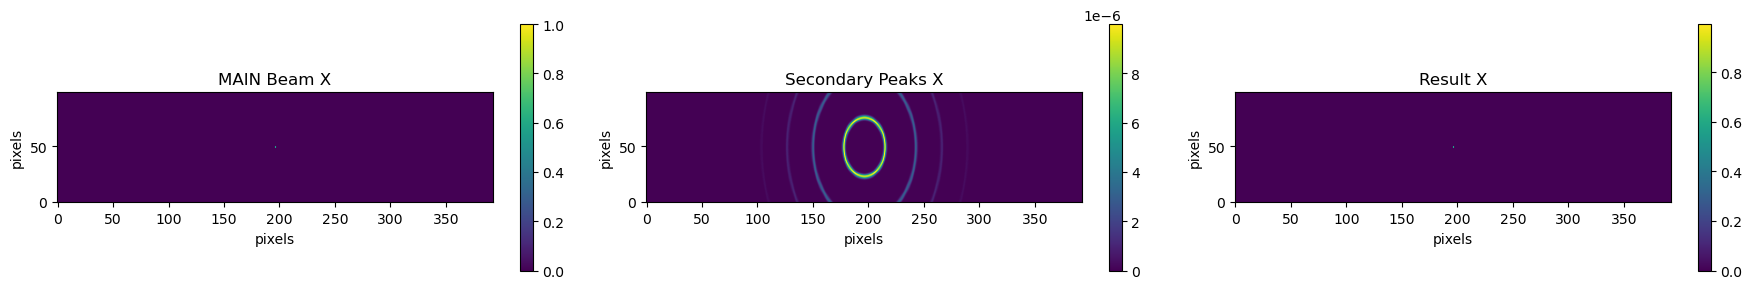

In [7]:
# COORDINATES LIKE THE ONES OF THE MAPS

Nx = int(Nx)
Ny = int(Ny)

onesx = np.ones(Nx)
onesy = np.ones(Ny)

indsx = (np.arange(Nx)+.5 - Nx/2.) * pix_size
indsy = (np.arange(Ny)+.5 - Ny/2.) * pix_size

#X = np.outer(onesy, indsx)
#Y = np.outer(indsy, onesx)
X = np.outer(onesy, indsx)
Y = np.outer(indsy, onesx)
R = np.sqrt(X**2. + Y**2.)


#####################################################################################

# VARIABLES

FWHM_x = 40  #degrees
FWHM_y = 60  #degrees
ellipticity = (FWHM_x - FWHM_y) / (FWHM_x + FWHM_y)
print("ellipticity = ", ellipticity)

array_dB = np.array([-20, -22, -24, -26]) #max values of the secondary peaks
array_dB = array_dB * 2.5
r1 = np.array([80000, 200000, 300000, 400000]) #angular distance of the peaks
r = 100 # width of the rings

theta = 0 # angle of rotation of the beam
a = 1 # major axis of ellipses 


#########################################################################################

# BEAM

beam_gauss_x, beam_gauss_y, sec_rings_x,sec_rings_y, beam_x, beam_y = create_beam_secpeaks(pix_size, FWHM_x, FWHM_y, theta, array_dB, r, r1, X, Y, a, ellipticity)

########################################################################################

# PLOT

fig, axes = plt.subplots(1, 3, figsize=(18, 3))
titles = ['MAIN Beam X', 'Secondary Peaks X', 'Result X']
data_list = [beam_gauss_x, sec_rings_x, beam_x]

for i, ax in enumerate(axes.flat):
    im = ax.imshow(data_list[i], cmap='viridis', origin='lower')
    ax.set_title(titles[i])
    ax.set_xlabel('pixels')
    ax.set_ylabel('pixels')
    cbar = plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

beam max: 4.342923104481638e-05 beam min: 0.8219591069514898


0

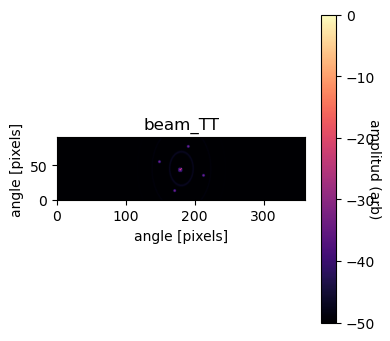

In [8]:
### beam systematics dictionary
bs = {"budy":{"A":1e-3,"FWHP":105.5,"R":2000.,"psi":0.3,"polfracQ":0.5,"polfracU":0.01},  
                                                                         # little budy amplitude, 
                                                                         #FWHP, offset spacing, rotationa angle (radians)
                                                                        # pol_fraction for Q and U
     "ghostshelf": {"A":1e-4,"Diam":200.,"roll_off":7.},    #model of ghosting, amplitude (A), diameter (Diam) 
     "hex_crostalk":{"grid_space": 100.,"N":1,"neighbor_exp_fall":0.01}, 
                                                                               ## model of optical cross talk 
                                                                               ## to detectors on a hex grid
                                                                               ## assumed to be exponetial
                                                                               ## assumed to be 50% polarized
      "TtoQ":{"mono":1e-3,"dip_x":1e-2,"dip_y":1e-2,"quad_x":1e-2,"quad_45":1e-2},
      "TtoU":{"mono":1e-3,"dip_x":1e-2,"dip_y":1e-2,"quad_x":1e-2,"quad_45":1e-2},
                                                                  ## multiplole expansion leakage
      'psi':0.01*np.pi/180.
                                  ## detetor angle rotations
                   }

beam_sys = BeamSystematics()
beam_TT, beam_QQ, beam_UU, beam_QT, beam_UT, beam_QU, beam_UQ = make_systematics_beams_r(Nx, Ny, pix_size, FWHM_x, beam_x, bs)


######################################################################################################################################
beam_to_plot = beam_TT
beam_to_plot = beam_to_plot / np.max(beam_to_plot) + 1e-5
beam_to_plot = 10. * np.log10(beam_to_plot)
Plot_beam_rectangular(beam_to_plot,np.min(beam_to_plot),np.max(beam_to_plot),X_width, Y_width,  "beam_TT", 'angle [pixels]')

In [9]:
# convolution with perfect beam
perf_beam, no1, no2, no3, no4, no5 = create_beam_secpeaks(pix_size, FWHM_x, FWHM_y, 0, array_dB, r, r1, X, Y, a, ellipticity)
perf_beam = perf_beam / np.sum(perf_beam)

Q_conv_perf_40 = convolve_map_with_beam(maps_2d['mp_hp_Q40'], perf_beam)
U_conv_perf_40 = convolve_map_with_beam(maps_2d['mp_hp_U40'], perf_beam)

Q_conv_perf_60 = convolve_map_with_beam(maps_2d['mp_hp_Q60'], perf_beam)
U_conv_perf_60 = convolve_map_with_beam(maps_2d['mp_hp_U60'], perf_beam)

Q_conv_perf_78 = convolve_map_with_beam(maps_2d['mp_hp_Q78'], perf_beam)
U_conv_perf_78 = convolve_map_with_beam(maps_2d['mp_hp_U78'], perf_beam)

Q_conv_perf_100 = convolve_map_with_beam(maps_2d['mp_hp_Q100'], perf_beam)
U_conv_perf_100 = convolve_map_with_beam(maps_2d['mp_hp_U100'], perf_beam)

Q_conv_perf_140 = convolve_map_with_beam(maps_2d['mp_hp_Q140'], perf_beam)
U_conv_perf_140 = convolve_map_with_beam(maps_2d['mp_hp_U140'], perf_beam)

Q_conv_perf_195 = convolve_map_with_beam(maps_2d['mp_hp_Q195'], perf_beam)
U_conv_perf_195 = convolve_map_with_beam(maps_2d['mp_hp_U195'], perf_beam)

Q_conv_perf_280 = convolve_map_with_beam(maps_2d['mp_hp_Q280'], perf_beam)
U_conv_perf_280 = convolve_map_with_beam(maps_2d['mp_hp_U280'], perf_beam)

Q_conv_perf_402 = convolve_map_with_beam(maps_2d['mp_hp_Q402'], perf_beam)
U_conv_perf_402 = convolve_map_with_beam(maps_2d['mp_hp_U402'], perf_beam)



# convolution with real beam
I_conv_real_40 = convolve_map_with_beam(maps_2d['mp_hp_I40'], beam_TT)
Q_conv_real_40 = convolve_map_with_beam(maps_2d['mp_hp_Q40'], beam_QQ)
U_conv_real_40 = convolve_map_with_beam(maps_2d['mp_hp_U40'], beam_UU)

I_conv_real_60 = convolve_map_with_beam(maps_2d['mp_hp_I60'], beam_TT)
Q_conv_real_60 = convolve_map_with_beam(maps_2d['mp_hp_Q60'], beam_QQ)
U_conv_real_60 = convolve_map_with_beam(maps_2d['mp_hp_U60'], beam_UU)

I_conv_real_78 = convolve_map_with_beam(maps_2d['mp_hp_I78'], beam_TT)
Q_conv_real_78 = convolve_map_with_beam(maps_2d['mp_hp_Q78'], beam_QQ)
U_conv_real_78 = convolve_map_with_beam(maps_2d['mp_hp_U78'], beam_UU)

I_conv_real_100 = convolve_map_with_beam(maps_2d['mp_hp_I100'], beam_TT)
Q_conv_real_100 = convolve_map_with_beam(maps_2d['mp_hp_Q100'], beam_QQ)
U_conv_real_100 = convolve_map_with_beam(maps_2d['mp_hp_U100'], beam_UU)

I_conv_real_140 = convolve_map_with_beam(maps_2d['mp_hp_I140'], beam_TT)
Q_conv_real_140 = convolve_map_with_beam(maps_2d['mp_hp_Q140'], beam_QQ)
U_conv_real_140 = convolve_map_with_beam(maps_2d['mp_hp_U140'], beam_UU)

I_conv_real_195 = convolve_map_with_beam(maps_2d['mp_hp_I195'], beam_TT)
Q_conv_real_195 = convolve_map_with_beam(maps_2d['mp_hp_Q195'], beam_QQ)
U_conv_real_195 = convolve_map_with_beam(maps_2d['mp_hp_U195'], beam_UU)

I_conv_real_280 = convolve_map_with_beam(maps_2d['mp_hp_I280'], beam_TT)
Q_conv_real_280 = convolve_map_with_beam(maps_2d['mp_hp_Q280'], beam_QQ)
U_conv_real_280 = convolve_map_with_beam(maps_2d['mp_hp_U280'], beam_UU)

I_conv_real_402 = convolve_map_with_beam(maps_2d['mp_hp_I402'], beam_TT)
Q_conv_real_402 = convolve_map_with_beam(maps_2d['mp_hp_Q402'], beam_QQ)
U_conv_real_402 = convolve_map_with_beam(maps_2d['mp_hp_U402'], beam_UU)

# Pol angle

In [11]:
#std_deviation_degree = 10
#std_deviation_rad    = std_deviation_degree * np.pi / 180
#gauss_center  = 0

#std_deviation_rad

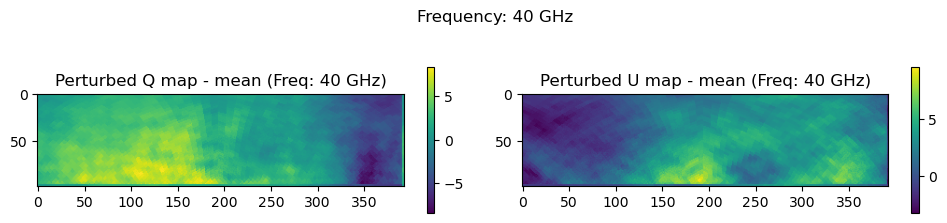

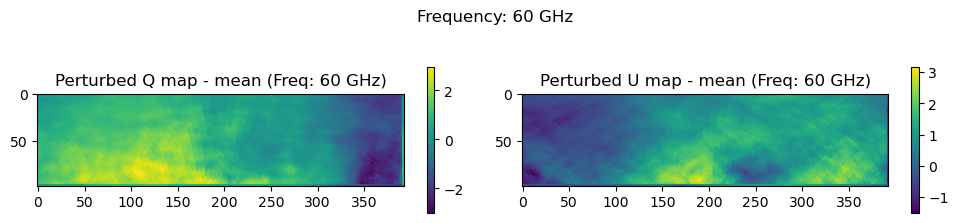

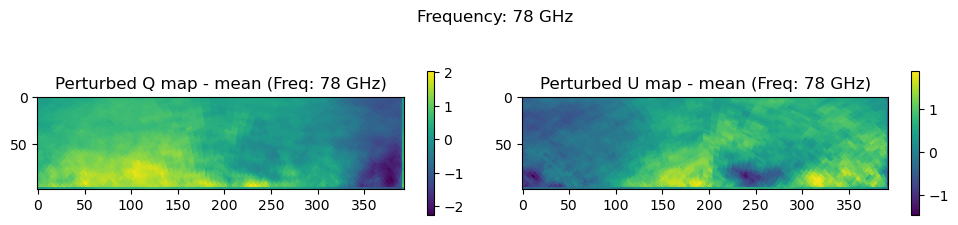

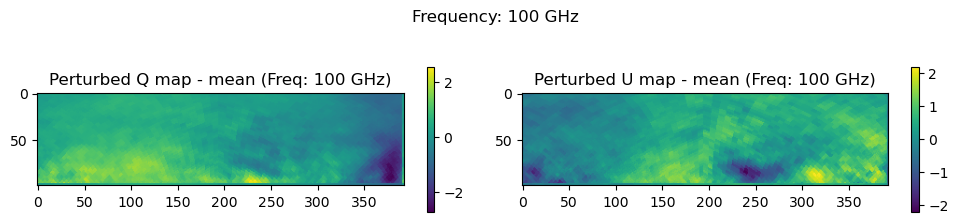

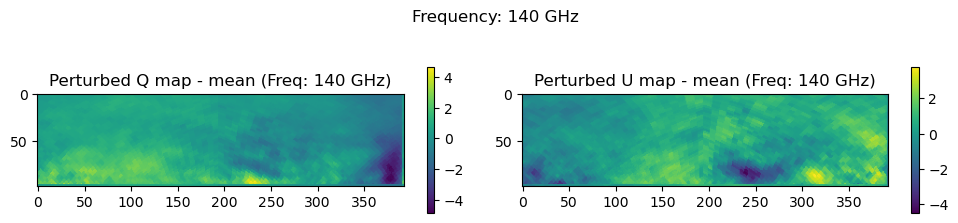

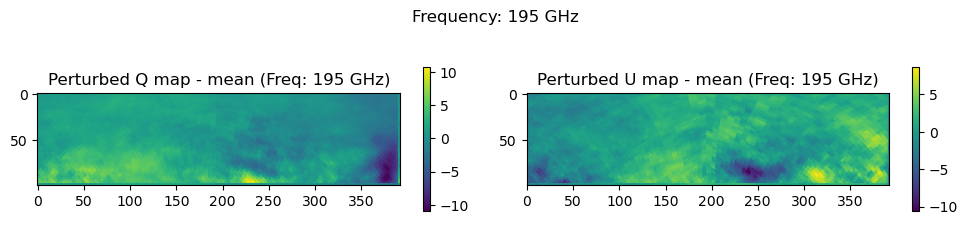

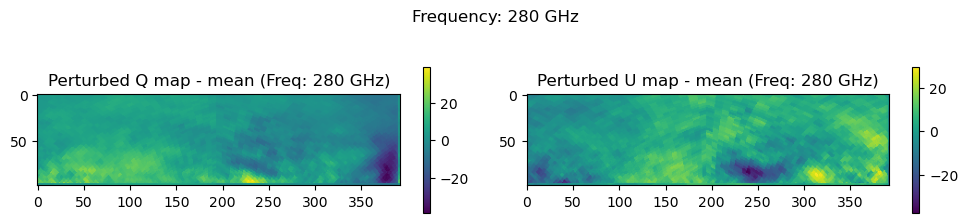

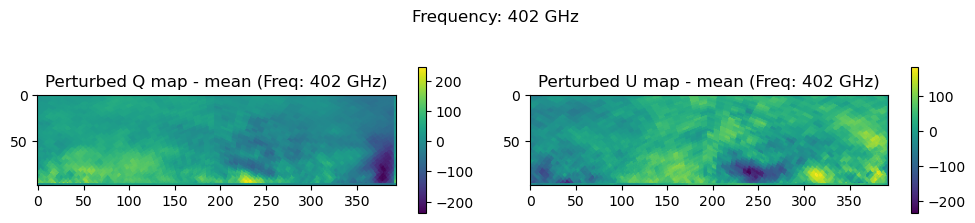

In [12]:
import random 
num_simulations = 10

std_deviation_rad =[random.uniform(0, 0.1) for _ in range(num_simulations)]
std_deviation_rad = np.sort(std_deviation_rad)
gauss_center  = 0



frequencies = [40, 60, 78, 100, 140, 195, 280, 402]

Q_maps = {
    40: Q_conv_real_40, 60: Q_conv_real_60, 78: Q_conv_real_78,
    100: Q_conv_real_100, 140: Q_conv_real_140, 195: Q_conv_real_195,
    280: Q_conv_real_280, 402: Q_conv_real_402}

U_maps = {
    40: U_conv_real_40, 60: U_conv_real_60, 78: U_conv_real_78,
    100: U_conv_real_100, 140: U_conv_real_140, 195: U_conv_real_195,
    280: U_conv_real_280, 402: U_conv_real_402}

Q_map_mean_all = {}
Q_map_std_all = {}
U_map_mean_all = {}
U_map_std_all = {}
Q_map_perturbed_all = {}
U_map_perturbed_all = {}


for freq in frequencies:
    Q_map = Q_maps[freq]
    U_map = U_maps[freq]
    
    Q_map_perturbed  = np.zeros((num_simulations, *Q_map.shape))
    U_map_perturbed  = np.zeros((num_simulations, *U_map.shape))

    
    for i in range(num_simulations):
        Q_map_pert, U_map_pert = polangle_map(Q_map, U_map, gauss_center, std_deviation_rad[i])
        Q_map_perturbed[i, :, :] = Q_map_pert
        U_map_perturbed[i, :, :] = U_map_pert
        
    Q_map_perturbed_all[freq] = Q_map_perturbed
    U_map_perturbed_all[freq] = U_map_perturbed

    # Calcolo media e deviazione standard
    Q_map_mean_all[freq] = np.mean(Q_map_perturbed, axis=0)
    Q_map_std_all[freq] = np.std(Q_map_perturbed, axis=0)
    U_map_mean_all[freq] = np.mean(U_map_perturbed, axis=0)
    U_map_std_all[freq] = np.std(U_map_perturbed, axis=0)

        
# le mappe si chiamano Q_map_perturbed_all[freq][num_sim, partendo da 0]
######################################################################################

for freq in frequencies:
    plt.figure(figsize=(10, 4))
    plt.suptitle(f'Frequency: {freq} GHz')
    
    plt.subplot(2, 2, 1)
    plt.imshow(Q_map_mean_all[freq], cmap='viridis')
    plt.title(f'Perturbed Q map - mean (Freq: {freq} GHz)')
    plt.colorbar()
       
    plt.subplot(2, 2, 2)
    plt.imshow(U_map_mean_all[freq], cmap='viridis')
    plt.title(f'Perturbed U map - mean (Freq: {freq} GHz)')
    plt.colorbar()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [13]:
# APODIZATION
window = (cosine_window_r(Nx, Ny, x_range=[-np.pi /4, np.pi /4], y_range=[-np.pi /4, np.pi /4]))

for freq in frequencies:
    for i in range(num_simulations):
        Q_map_perturbed_all[freq][i] *= window
        U_map_perturbed_all[freq][i] *= window

In [14]:
#np.shape(Q_map_std_all[40][0])
np.shape(Q_map_std_all[40])

(99, 393)

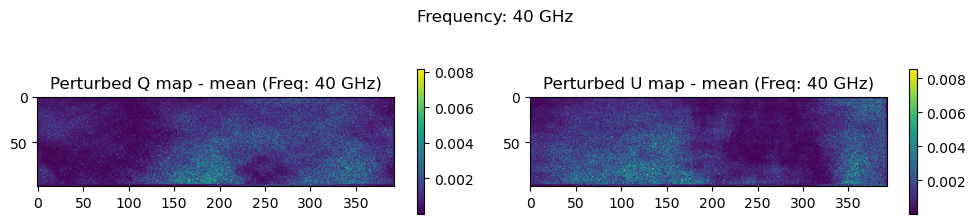

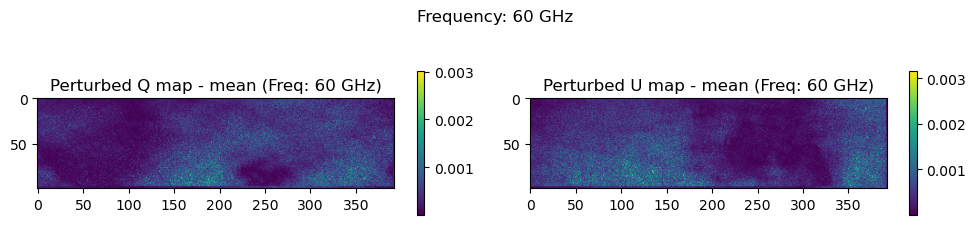

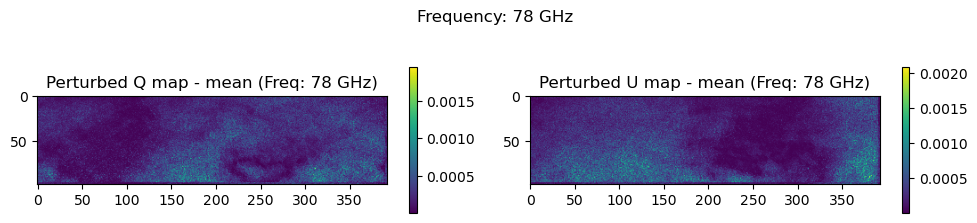

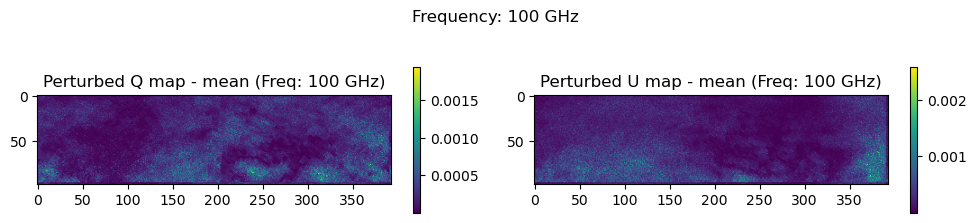

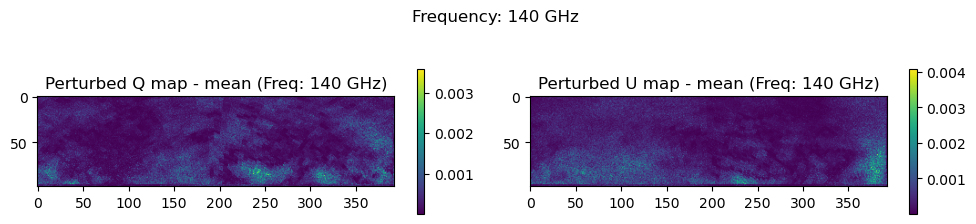

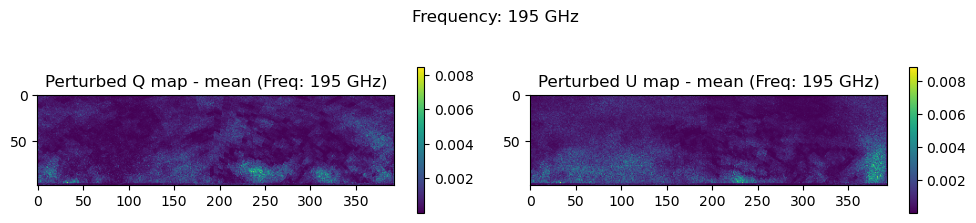

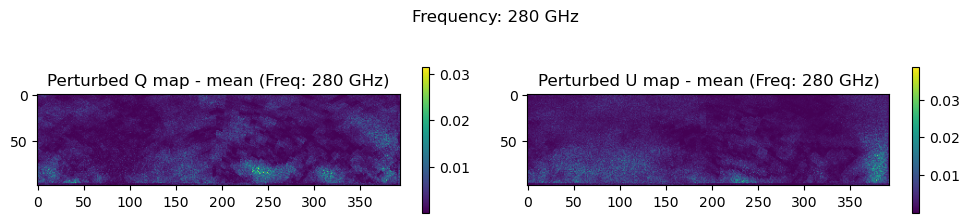

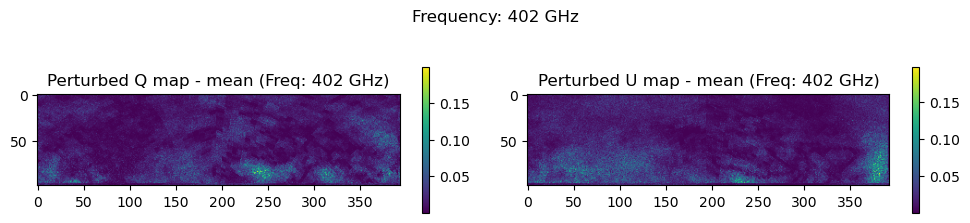

In [15]:
Q_err_all = {}
U_err_all = {}

for freq in frequencies:
    Q_err_all[freq] = Q_map_std_all[freq] / np.sqrt((Nx*Ny))
    U_err_all[freq] = U_map_std_all[freq] / np.sqrt((Nx*Ny))
    
    
    
for freq in frequencies:
    plt.figure(figsize=(10, 4))
    plt.suptitle(f'Frequency: {freq} GHz')
    
    plt.subplot(2, 2, 1)
    plt.imshow(Q_err_all[freq], cmap='viridis')
    plt.title(f'Perturbed Q map - mean (Freq: {freq} GHz)')
    plt.colorbar()
       
    plt.subplot(2, 2, 2)
    plt.imshow(U_err_all[freq], cmap='viridis')
    plt.title(f'Perturbed U map - mean (Freq: {freq} GHz)')
    plt.colorbar()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

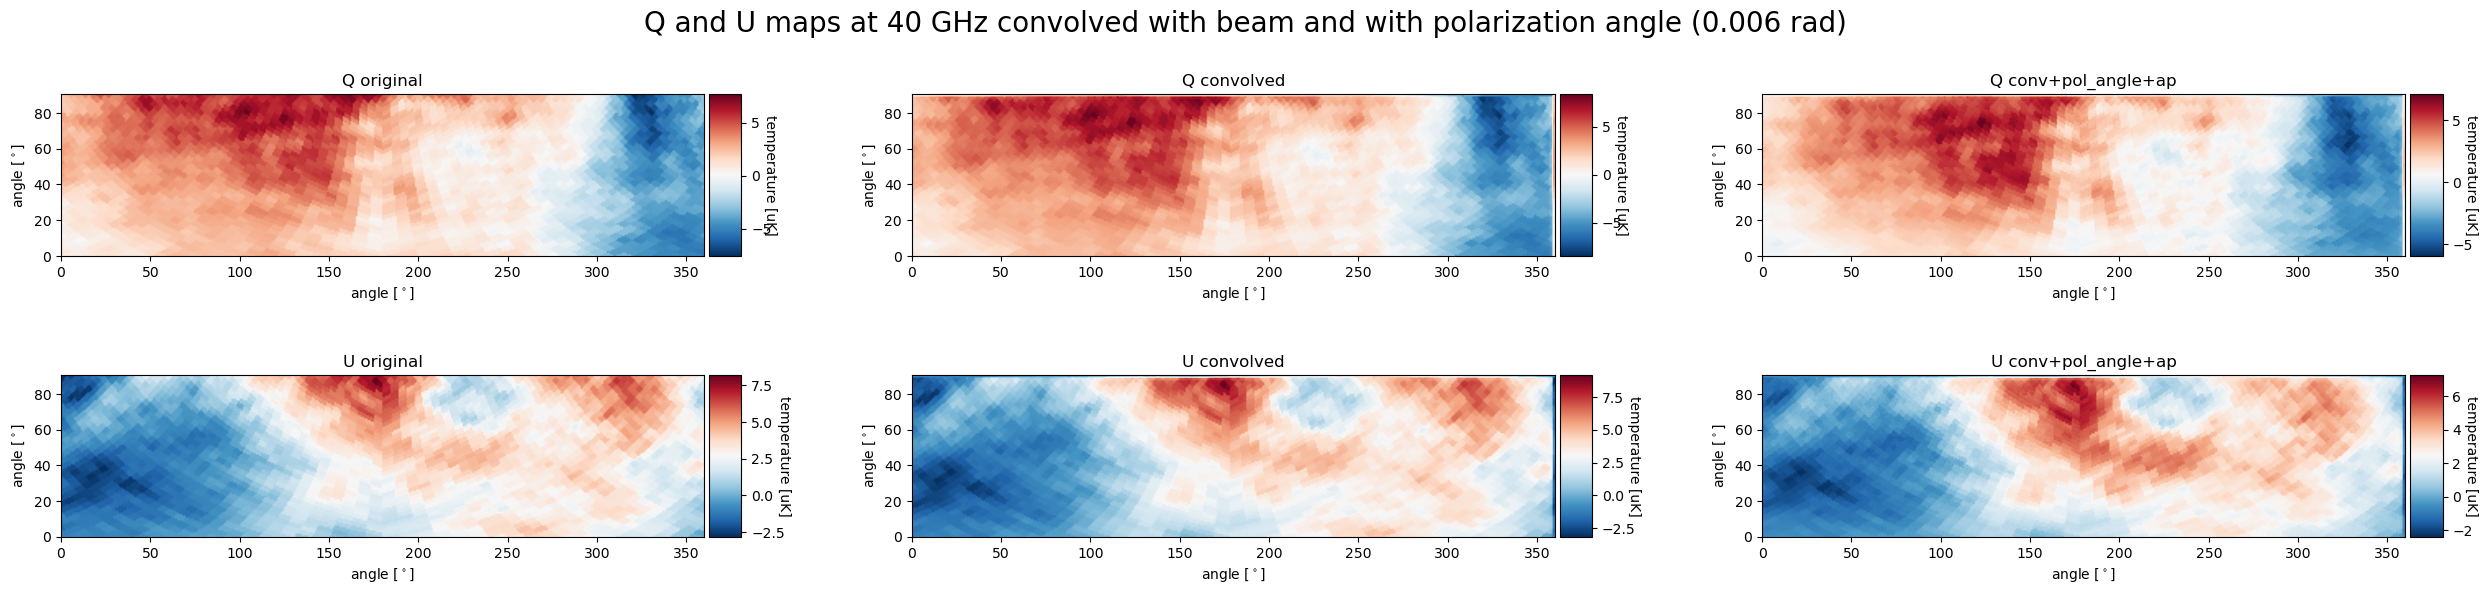

In [16]:
# plot - 1 frequenza (40) per una simulazione (1°)
Map_to_Plot = [maps_2d['mp_hp_Q40'], Q_conv_real_40, Q_map_perturbed_all[40][0], maps_2d['mp_hp_U40'], U_conv_real_40, U_map_perturbed_all[40][0]]
title = ["Q original","Q convolved", "Q conv+pol_angle+ap", "U original","U convolved", "U conv+pol_angle+ap"]
c_factor_max = [np.max(Map_to_Plot[0]), np.max(Map_to_Plot[1]), np.max(Map_to_Plot[2]), np.max(Map_to_Plot[3]), np.max(Map_to_Plot[4]), np.max(Map_to_Plot[5])]
c_factor_min = [np.min(Map_to_Plot[0]), np.min(Map_to_Plot[1]), np.min(Map_to_Plot[2]), np.min(Map_to_Plot[3]), np.min(Map_to_Plot[4]), np.min(Map_to_Plot[5])]

fig, axs = plt.subplots(2, 3, figsize=(25, 6))
axs      = axs.flatten()
for i, (map_data, c_factor_iter_min, c_factor_iter_max) in enumerate(zip(Map_to_Plot, c_factor_min, c_factor_max)):
        Plot_CMB_Map_compact(axs[i], map_data, c_factor_iter_min, c_factor_iter_max, X_width, Y_width)
        axs[i].set_title(title[i])

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)
plt.suptitle(f'Q and U maps at {frequencies[0]} GHz convolved with beam and with polarization angle ({(std_deviation_rad[0]):.3f} rad)', fontsize=20)
#plt.savefig('/Users/guide/Documents/University/TESI/immagini/FullModelPerturbation.png')
plt.show()


# Component Separation

In [17]:
idx = hp.ang2pix(nside, ra_hp, dec_hp, lonlat=True)


Q_flat_all = {}
U_flat_all = {}

for freq in frequencies:
    Q_map = Q_map_perturbed_all[freq]
    U_map = U_map_perturbed_all[freq]
    
    Q_map_flat  = np.zeros((num_simulations,*I40.shape))
    U_map_flat  = np.zeros((num_simulations,*I40.shape))
    
    
    for i in range(num_simulations):
        new_map_Q = np.zeros_like(I40) 
        new_map_Q[idx] = Q_map_perturbed_all[freq][i].flatten()
        Q_map_flat[i] = new_map_Q  # Store the new map in the flat array
        
        
        new_map_U = np.zeros_like(I40) 
        new_map_U[idx] = U_map_perturbed_all[freq][i].flatten()
        U_map_flat[i] = new_map_U
        
        
    Q_flat_all[freq] = Q_map_flat
    U_flat_all[freq] = U_map_flat   

In [18]:
n_pixels = I40.size
Q_flat_all = {}
U_flat_all = {}

# Populate Q_flat_all and U_flat_all with flattened maps for each frequency and simulation
# Replace this with your actual code to populate Q_flat_all and U_flat_all
for freq in frequencies:
    Q_map = Q_map_perturbed_all[freq]
    U_map = U_map_perturbed_all[freq]
    
    Q_map_flat  = np.zeros((num_simulations, n_pixels))
    U_map_flat  = np.zeros((num_simulations, n_pixels))
    
    for i in range(num_simulations):
        new_map_Q = np.zeros_like(I40)
        new_map_Q[idx] = Q_map[i].flatten()
        Q_map_flat[i] = new_map_Q
        
        new_map_U = np.zeros_like(I40)
        new_map_U[idx] = U_map[i].flatten()
        U_map_flat[i] = new_map_U
        
    Q_flat_all[freq] = Q_map_flat
    U_flat_all[freq] = U_map_flat

# Now create the full_array with the desired shape (8, 2, num_simulations, 49152)
full_array = np.zeros((len(frequencies), 2, num_simulations, n_pixels))

for f_idx, freq in enumerate(frequencies):
    Q_stack = Q_flat_all[freq]
    U_stack = U_flat_all[freq]
    
    # Stack Q and U maps for the current frequency
    freq_stack = np.stack([Q_stack, U_stack], axis=0)  # Shape (2, num_simulations, 49152)
    
    # Assign to the full_array
    full_array[f_idx] = freq_stack

# Print the shape of the full_array to verify
print(full_array.shape)  # Expected shape: (8, 2, 10, 49152)

# If you want a different shape like (num_simulations, 8, 2, 49152), you can transpose it
full_array = full_array.transpose(2, 0, 1, 3)
print(full_array.shape)  # Expected shape: (10, 8, 2, 49152)

(8, 2, 10, 49152)
(10, 8, 2, 49152)


full_array contiene le 10 simulazioni , 8 frequenze, 2 mappe (Q,U) con 49152 pixels

In [19]:
np.shape(full_array[0])

(8, 2, 49152)

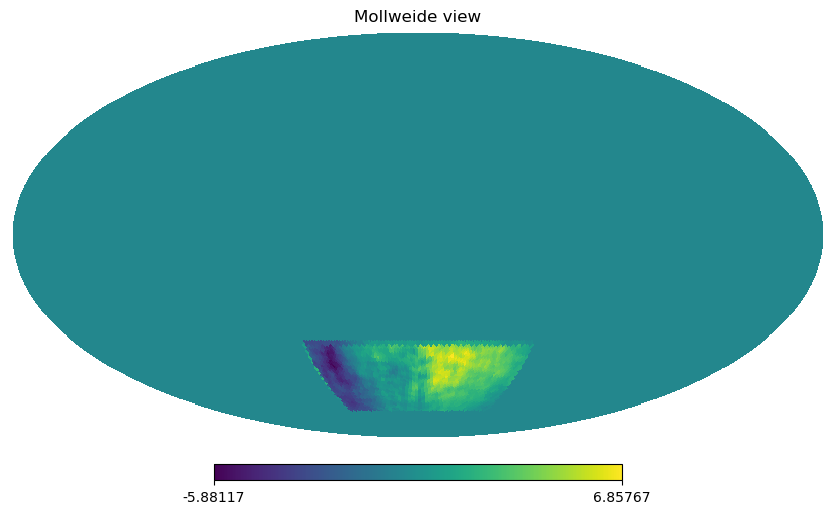

In [20]:
hp.mollview(full_array[0,0, 0]) # prova : simulazione 1°, frequenza 40, mappa Q

In [21]:
instrument = get_instrument('LiteBIRD')

df   = pd.DataFrame(instrument)
freq = df.iloc[[0, 2, 4, 6, 8, 10, 12, 14], :]   #estraggo le frequenze che ho selezionato creando le patch

freq

frequency  depth_p  depth_i  fwhm  f_sky    status  \
0        40.0    37.42    26.46  70.5    1.0  forecast   
2        60.0    21.31    15.07  51.1    1.0  forecast   
4        78.0    12.07     8.53  43.8    1.0  forecast   
6       100.0     6.56     4.64  37.8    1.0  forecast   
8       140.0     4.79     3.39  30.8    1.0  forecast   
10      195.0     5.85     4.14  28.6    1.0  forecast   
12      280.0    13.80     9.76  22.5    1.0  forecast   
14      402.0    47.45    33.55  17.9    1.0  forecast   

                     reference       type  \
0   arXiv:2202.02773, Table 13  satellite   
2   arXiv:2202.02773, Table 13  satellite   
4   arXiv:2202.02773, Table 13  satellite   
6   arXiv:2202.02773, Table 13  satellite   
8   arXiv:2202.02773, Table 13  satellite   
10  arXiv:2202.02773, Table 13  satellite   
12  arXiv:2202.02773, Table 13  satellite   
14  arXiv:2202.02773, Table 13  satellite   

                                                 note experiment  
0   Different instruments at the same freq were co...   LiteBIRD  
2   Different instruments at the same freq were co...   LiteBIRD  
4   Different instruments at the same freq were co...   LiteBIRD  
6   Different instruments at the same freq were co...   LiteBIRD  
8   Different instruments at the same freq were co...   LiteBIRD  
10  Different instruments at the same freq were co...   LiteBIRD  
12  Different instruments at the same freq were co...   LiteBIRD  
14  Different instruments at the same freq were co...   LiteBIRD

In [22]:
components = [CMB(), Dust(350.), Synchrotron(20.)]
results = []
cmb_I = {}
cmb_Q = {}
cmb_U = {}

for i in range(num_simulations):
    result = basic_comp_sep(components, freq, full_array[i])
    results.append(result)

    # Print the results for this simulation
    print(f"Simulation {i+1}")
    print(result.params)
    print(result.x)

    #cmb_I[i]  = result.s[0, 0]
    cmb_Q[i]  = result.s[0, 0]
    cmb_U[i]  = result.s[0, 1]

Simulation 1
['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']
[ 1.49857997 24.02164519 -2.94723118]
Simulation 2
['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']
[ 1.46254533 26.39616227 -2.94026916]
Simulation 3
['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']
[ 1.47173881 25.61644041 -2.93961775]
Simulation 4
['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']
[ 1.46616396 26.39064787 -2.92816595]
Simulation 5
['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']
[ 1.3956626  32.35314506 -2.88893379]
Simulation 6
['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']
[ 1.40555513 31.15838342 -2.87359543]
Simulation 7
['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']
[ 1.44007647 28.51426587 -2.9009586 ]
Simulation 8
['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']
[ 1.11166508e+00  6.81127783e+08 -2.66874895e+00]
Simulation 9
['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']
[ 1.12954112e+00  2.49671769e+08 -2.40351370e+00]
Simulation 10
['Dust.beta_d', 'Dust.temp', 'Synch

In [23]:
np.shape(cmb_Q[0])

(49152,)

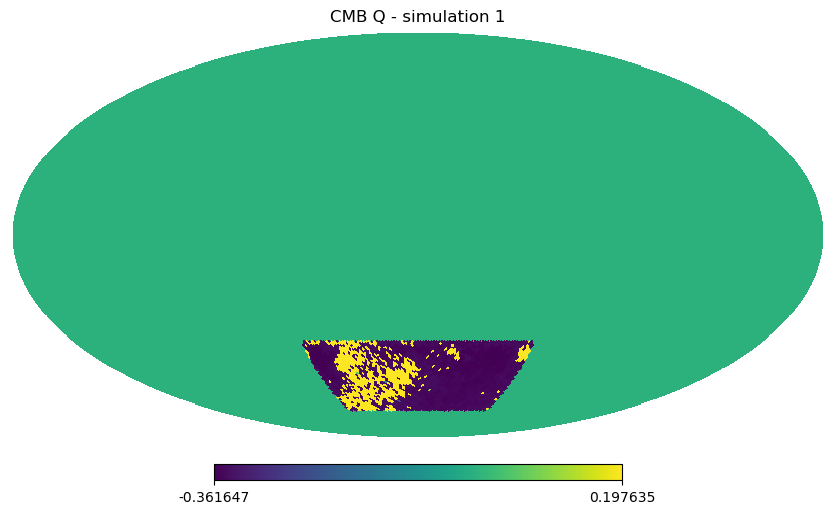

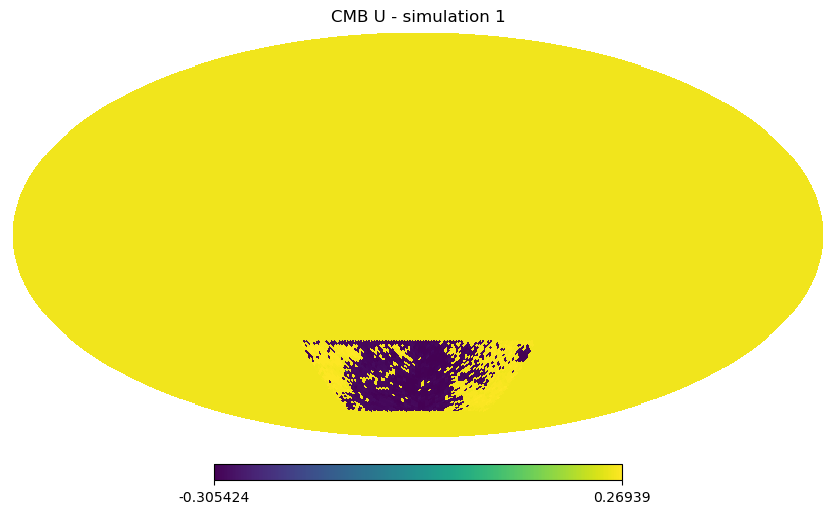

In [24]:
hp.mollview(cmb_Q[0], title='CMB Q - simulation 1', norm='hist')
hp.mollview(cmb_U[0], title='CMB U - simulation 1', norm='hist')

# Deconvolution

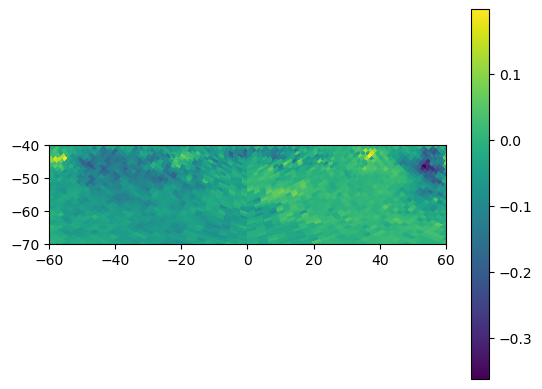

In [25]:
# torno in 2D
cmb_Q_2d = {}
cmb_U_2d = {}

for i in range (num_simulations):
    # cmb_I_2d[i], ra_hp, dec_hp = convert2grid(cmb_Q, nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)
    cmb_Q_2d[i], ra_hp, dec_hp = convert2grid(cmb_Q[i], nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)
    cmb_U_2d[i], ra_hp, dec_hp = convert2grid(cmb_U[i], nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)
    
plt.figure()
plt.imshow(cmb_Q_2d[0],origin='lower', extent=extent)
plt.colorbar()

In [26]:
import pymaster as nmt

In [27]:
Q_deconv = {}
U_deconv = {}

for i in range (num_simulations):
    Q_deconv[i] = deconvolve_map(cmb_Q_2d[i], beam_x, perf_beam)
    U_deconv[i] = deconvolve_map(cmb_U_2d[i], beam_x, perf_beam)
    

########################################################################################
# side lobes

Q_conv_perf = {}
U_conv_perf = {}
Q_diff = {}
U_diff = {}

for i in range (num_simulations):
    Q_conv_perf[i] = convolve_map_with_beam(cmb_Q_2d[i], perf_beam)
    U_conv_perf[i] = convolve_map_with_beam(cmb_U_2d[i], perf_beam)
    
    Q_diff[i] = (Q_conv_perf[i]- Q_deconv[i])
    U_diff[i] = (U_conv_perf[i]- U_deconv[i])

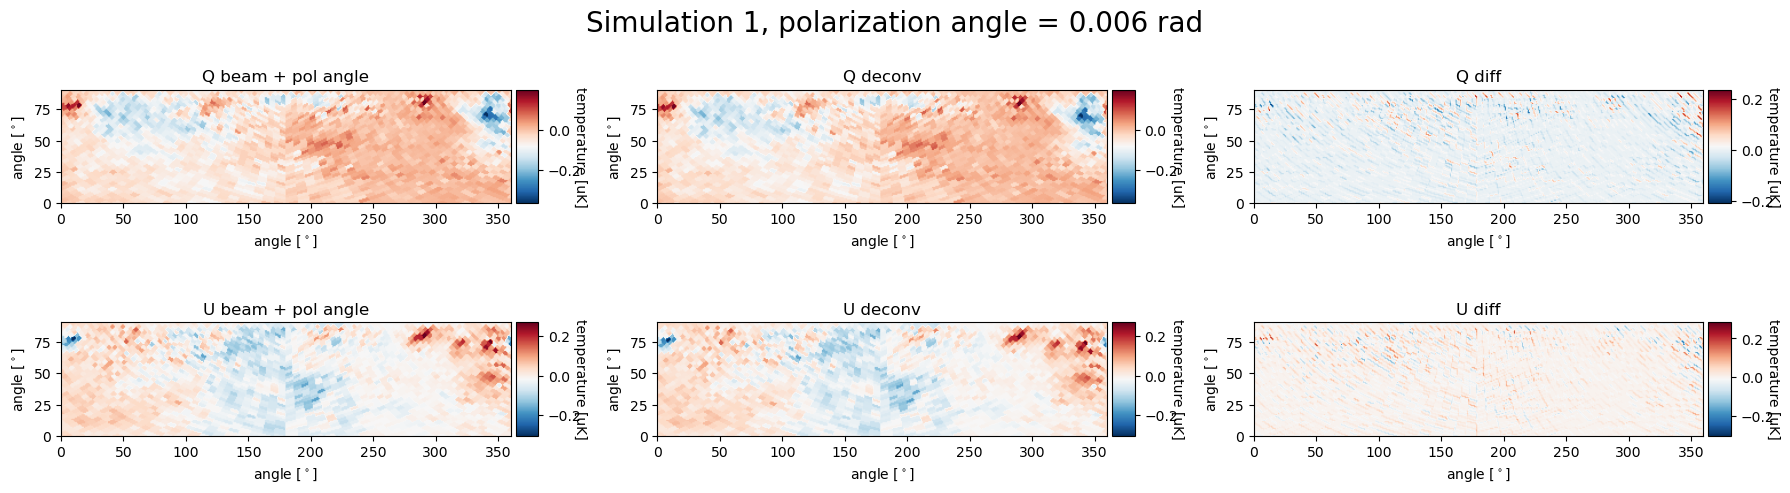

In [28]:
Map_to_Plot = [cmb_Q_2d[0],Q_deconv[0], Q_diff[0], cmb_U_2d[0] ,U_deconv[0], U_diff[0]]
title = ["Q beam + pol angle", "Q deconv", "Q diff", "U beam + pol angle", "U deconv", "U diff"]
c_factor_max = [np.max(Map_to_Plot[0]), np.max(Map_to_Plot[1]), np.max(Map_to_Plot[2]), np.max(Map_to_Plot[3]), np.max(Map_to_Plot[4]), np.max(Map_to_Plot[5])]
c_factor_min = [np.min(Map_to_Plot[0]), np.min(Map_to_Plot[1]), np.min(Map_to_Plot[2]), np.min(Map_to_Plot[3]), np.min(Map_to_Plot[4]), np.min(Map_to_Plot[5])]



fig, axs = plt.subplots(2, 3, figsize=(18, 5))
axs      = axs.flatten()
for i, (map_data, c_factor_iter_min, c_factor_iter_max) in enumerate(zip(Map_to_Plot, c_factor_min, c_factor_max)):
        Plot_CMB_Map_compact(axs[i], map_data, c_factor_iter_min, c_factor_iter_max, X_width, Y_width)
        axs[i].set_title(title[i])

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)
plt.suptitle(f'Simulation 1, polarization angle = {std_deviation_rad[0]:.3f} rad', fontsize=20)
plt.show()


# Power spectra with NaMaster

In [29]:
import pymaster as nmt

pix_size_rad = np.radians(pix_size /60)

X_width_rad = Nx * pix_size_rad
Y_width_rad = Ny * pix_size_rad


# Masks:
mask = np.ones_like(Q_deconv[0])

# bins
l0_bins = np.arange(Nx) * 8 * np.pi/X_width_rad
lf_bins = (np.arange(Nx)+1) * 8 * np.pi/X_width_rad
b = nmt.NmtBinFlat(l0_bins, lf_bins)

# The effective sampling rate for these bandpowers can be obtained calling:
ells_uncoupled = b.get_effective_ells()

BB_PS = {}
EE_PS = {}

for i in range (num_simulations):
    # fields
    Q = Q_deconv[i]
    U = U_deconv[i]
    
    f2 = nmt.NmtFieldFlat(X_width_rad, Y_width_rad, mask, [Q, U], purify_b=True)
   
    cl22_coupled = nmt.compute_coupled_cell_flat(f2, f2, b)
    
    EE_PS[i] = cl22_coupled[0]
    BB_PS[i] = cl22_coupled[3]
    



(1.5, 500)

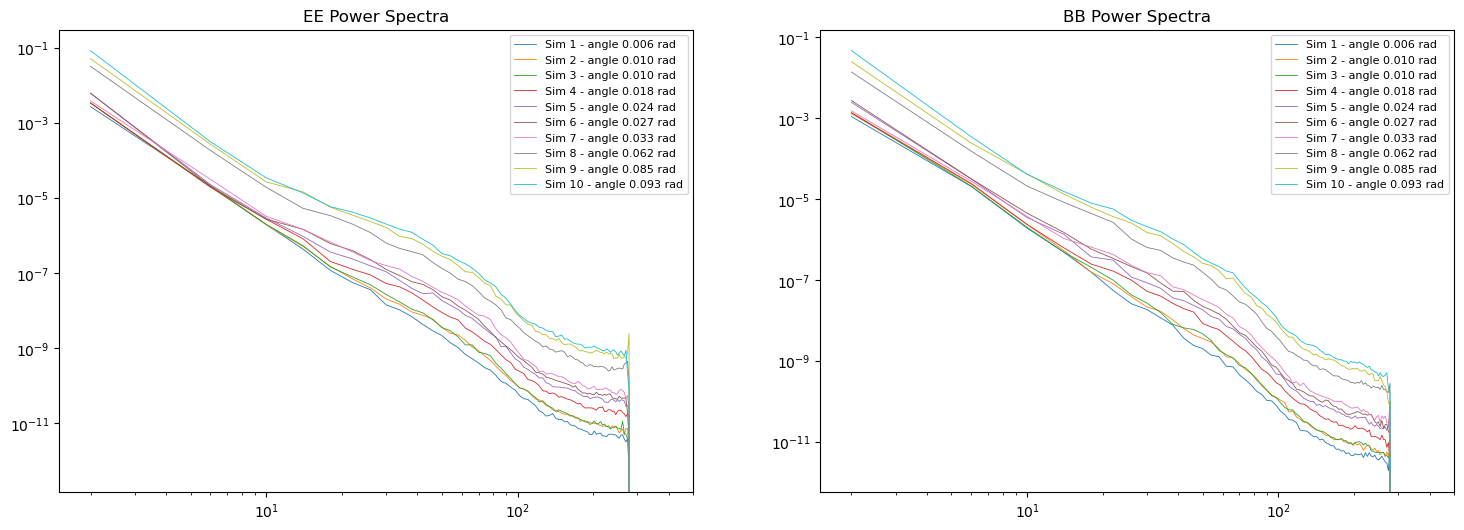

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
factor = ells_uncoupled*(ells_uncoupled+1) /(2*np.pi)


colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']


# Plot EE power spectra
ax[0].set_title('EE Power Spectra')


for i in range(num_simulations):
    color = colors[i % len(colors)]
    ax[0].plot(ells_uncoupled, EE_PS[i]/factor, color=color, linewidth=0.6, label=f'Sim {i+1} - angle {std_deviation_rad[i]:.3f} rad')
    
ax[0].loglog()
ax[0].legend(fontsize=8)
ax[0].set_xlim(1.5,500)

# Plot BB power spectra
ax[1].set_title('BB Power Spectra')

for i in range(num_simulations):
    color = colors[i % len(colors)]
    ax[1].plot(ells_uncoupled, BB_PS[i]/factor, color=color, linewidth=0.6, label=f'Sim {i+1} - angle {std_deviation_rad[i]:.3f} rad')
    
ax[1].loglog()
ax[1].legend(fontsize=8)
ax[1].set_xlim(1.5,500)

Questi sono gli spettri delle mappe di sola CMB dopo la deconvoluzione, qunidi alla fine dell'analisi, per le 10 simulazioni

# Confronto Ps
Confronto i PS ottenuti alla fine dell'analisi con
- quelli della patch originale (quindi senza nessuna sistematica) (ma devo prima fare la comonent separation per avere la cmb)
- quelli della patch con beam+angl+ap prima della deconvoluzione (ho già la cmb)
- quelli dei side lobes

### PS patch originale
Mi servono solo 3 mappe I, Q, U e di sola cmb, quindi faccio la component separation sulle mappe (già in 1d) chiamate I40, Q_40 etc
- component separation
- trasformo in 2d
- PS

In [31]:
freq40_or = np.stack([Q40, U40])
freq60_or = np.stack([Q60, U60])
freq78_or = np.stack([Q78, U78])
freq100_or = np.stack([Q100, U100])
freq140_or = np.stack([Q140, U140])
freq195_or = np.stack([Q195, U195])
freq280_or = np.stack([Q280, U280])
freq402_or = np.stack([Q402, U402])


full_array_or = np.array([freq40_or, freq60_or, freq78_or, freq100_or, freq140_or, freq195_or, freq280_or, freq402_or])
np.shape(full_array_or)


#################################################################
components = [CMB(), Dust(350.), Synchrotron(20.)]

# component separation
result_or = basic_comp_sep(components, freq, full_array_or)

print(result_or.params)
print(result_or.x)

#cmb_I_or  = result_or.s[0,0]
cmb_Q_or  = result_or.s[0,0]
cmb_U_or  = result_or.s[0,1]

['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']
[ 1.48832235 24.18548074 -2.94237242]


In [32]:
#cmb_I_2d_or, _, _ = convert2grid(cmb_I_or, nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)
cmb_Q_2d_or, _, _ = convert2grid(cmb_Q_or, nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)
cmb_U_2d_or, _, _ = convert2grid(cmb_U_or, nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)

<Figure size 640x480 with 0 Axes>

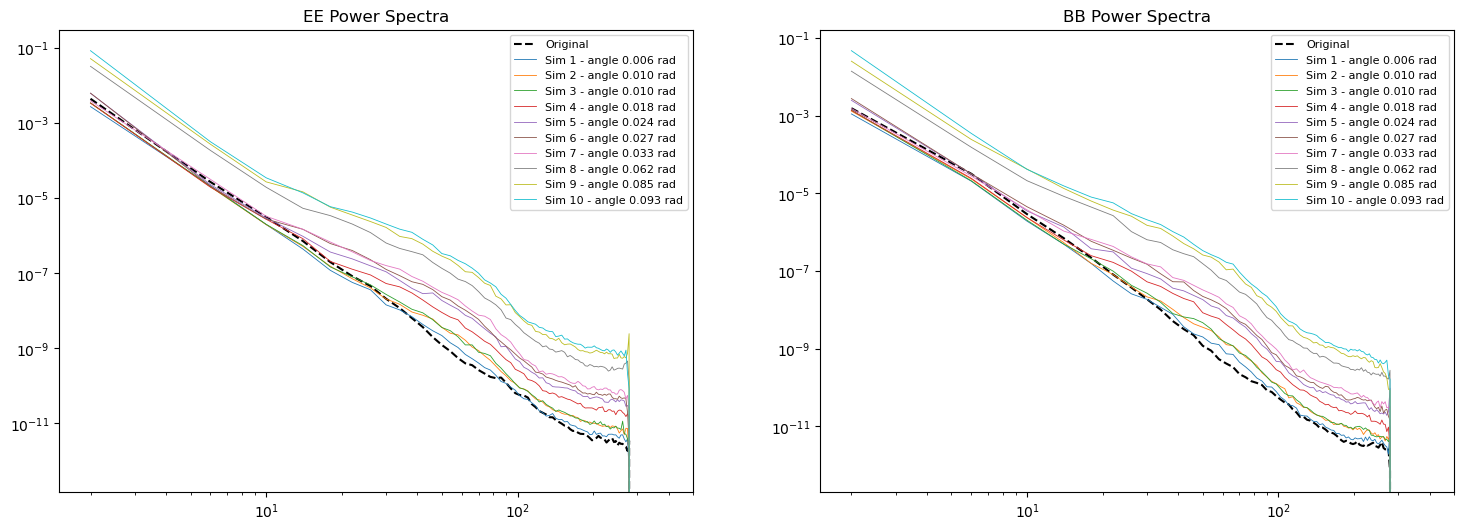

In [33]:
# Masks:
mask_or = np.ones_like(cmb_Q_2d_or)

# Fields:
#f0_or = nmt.NmtFieldFlat(X_width_rad, Y_width_rad, mask, [cmb_I_2d_or])
f2_or = nmt.NmtFieldFlat(X_width_rad, Y_width_rad, mask, [cmb_Q_2d_or, cmb_U_2d_or], purify_b=True)

# Bins:
l0_bins_or = np.arange(Nx) * 8 * np.pi/X_width_rad
lf_bins_or = (np.arange(Nx)+1) * 8 * np.pi/X_width_rad
b_or = nmt.NmtBinFlat(l0_bins_or, lf_bins_or)

# The effective sampling rate for these bandpowers can be obtained calling:
ells_uncoupled_or = b_or.get_effective_ells()

##############################################################################################################

cl22_coupled_or = nmt.compute_coupled_cell_flat(f2_or, f2_or, b_or)

########################################################################################

plt.figure()
fig, ax = plt.subplots(1,2, figsize = (18,6))


colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']


# Plot EE power spectra
ax[0].set_title('EE Power Spectra')
ax[0].plot(ells_uncoupled_or, cl22_coupled_or[0]/factor, 'black', label='Original', linewidth=1.5, linestyle='--')

for i in range(num_simulations):
    color = colors[i % len(colors)]
    ax[0].plot(ells_uncoupled, EE_PS[i]/factor, color=color, linewidth=0.6, label=f'Sim {i+1} - angle {std_deviation_rad[i]:.3f} rad')
    
ax[0].loglog()
ax[0].legend(fontsize=8)
ax[0].set_xlim(1.5,500)


# Plot BB power spectra
ax[1].set_title('BB Power Spectra')
ax[1].plot(ells_uncoupled_or, cl22_coupled_or[3]/factor, 'black', label='Original', linewidth=1.5, linestyle='--')

for i in range(num_simulations):
    color = colors[i % len(colors)]
    ax[1].plot(ells_uncoupled, BB_PS[i]/factor, color=color, linewidth=0.6, label=f'Sim {i+1} - angle {std_deviation_rad[i]:.3f} rad')
    
ax[1].loglog()
ax[1].legend(fontsize=8)
ax[1].set_xlim(1.5,500)


'''

# EE
ax[1].set_title('EE Power Spectra')
ax[1].plot(ells_uncoupled, cl22_coupled[0], 'r', label='After analysis', linewidth=0.6)

ax[1].loglog()
ax[1].legend()

# BB
ax[2].set_title('BB Power Spectra')
ax[2].plot(ells_uncoupled, cl22_coupled[3], 'r', label='After analysis', linewidth=0.6)
ax[2].plot(ells_uncoupled_or, cl22_coupled_or[3], 'g', label='Original', linewidth=0.6)
ax[2].loglog()
ax[2].legend()
'''

plt.show()

### r forecast

In [37]:
from fgbuster import xForecast, CMB, Dust, Synchrotron

for i in range(num_simulations):
    print(f'SIMULATION {i+1}, angle = {std_deviation_rad[i]:.3f} rad')
    print('\n')
    res = xForecast(components, freq, full_array[i], 2, 2*nside-1, Alens=0.1, r=0.01, make_figure=False)
    print('\n')
    print('\n')

SIMULATION 1, angle = 0.006 rad


fsky =  0.052652994791666664
======= ESTIMATION OF SPECTRAL PARAMETERS =======
res.x =  [ 1.49857997 24.02164519 -2.94723118]
======= ESTIMATION OF NOISE AFTER COMP SEP =======
======= COMPUTATION OF CL_FGS =======
======= ESTIMATION OF STAT AND SYS RESIDUALS =======
======= OPTIMIZATION OF COSMO LIKELIHOOD =======
bounds on r =  0.023809677173803584  /  0.02493409369951878
starting point =  0.02436540009125466
    ===>> fitted r =  [0.02425184]
======= ESTIMATION OF SIGMA(R) =======
ind_sr_min =  0
sr_grid[ind_sr_min-1] =  [1.]
sr_grid[ind_sr_min+1] =  [0.02831698]
sr_grid =  [[0.02425184]
 [0.02831698]
 [0.03306353]
 [0.03860571]
 [0.04507688]
 [0.05263276]
 [0.06145517]
 [0.07175642]
 [0.08378438]
 [0.0978285 ]
 [0.11422671]
 [0.13337364]
 [0.15573001]
 [0.1818338 ]
 [0.21231316]
 [0.24790154]
 [0.28945532]
 [0.33797443]
 [0.39462641]
 [0.46077452]
 [0.53801052]
 [0.62819298]
 [0.733492  ]
 [0.85644148]
 [1.        ]]
case # 1
bounds on sigma(r) =  